<a href="https://colab.research.google.com/github/realnihal/Chatting_app_flutter/blob/main/PneumoniaDetectionVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the Data

In [ ]:
from google.colab import files
files.upload()

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
 ! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:42<00:00, 73.2MB/s]
100% 2.29G/2.29G [00:42<00:00, 57.4MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

## Data Preprocessing

In [7]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [8]:
dir_path = "/content/chest_xray"

In [9]:
train_p = os.path.join(dir_path, "train")
test_p =os.path.join(dir_path, "test")
val_p = os.path.join(dir_path, "val")

In [10]:
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [11]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


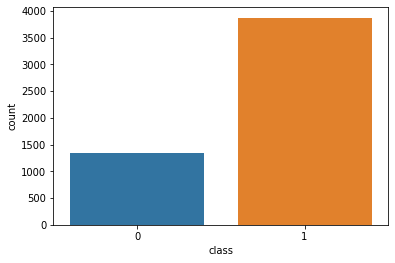

In [12]:
sns.countplot(df['class'],data=df)

In [13]:
# Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_ds = ImageDataGenerator(rescale =1/255, shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [14]:
''' VGG16 Model '''

model1 = VGG16(include_top = False,weights='imagenet')

''' freezing layers '''
for i in model1.layers:
    i.trainable=False
    
out = model1.output

''' GlobalAveragePooling Layer '''
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(128, activation='relu')(out)

''' Classification Layer '''
pred = keras.layers.Dense(1, activation='sigmoid')(out)

''' final model '''
model= keras.Model(model1.input, pred)

lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' Compile the model '''
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr_schedule), metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
train_ds = train_ds.flow_from_directory(train_p, target_size=(150,150), batch_size= 16, class_mode='binary')
val_ds = val_datagen.flow_from_directory(val_p, target_size=(150,150),batch_size=8, class_mode='binary')
test_ds = val_datagen.flow_from_directory(test_p, target_size=(150,150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
history = model.fit(train_ds, steps_per_epoch = 100, epochs=20, validation_data=val_ds)

Epoch 1/20
100/100 [==============================] - 32s 286ms/step - loss: 2.8221 - accuracy: 0.7487 - val_loss: 0.6536 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 28s 276ms/step - loss: 0.3712 - accuracy: 0.8637 - val_loss: 1.3884 - val_accuracy: 0.6875
Epoch 3/20
100/100 [==============================] - 28s 279ms/step - loss: 0.3429 - accuracy: 0.8650 - val_loss: 0.2964 - val_accuracy: 0.8750
Epoch 4/20
100/100 [==============================] - 28s 282ms/step - loss: 0.2787 - accuracy: 0.8925 - val_loss: 0.4274 - val_accuracy: 0.8125
Epoch 5/20
100/100 [==============================] - 28s 278ms/step - loss: 0.2800 - accuracy: 0.9019 - val_loss: 0.4309 - val_accuracy: 0.7500
Epoch 6/20
100/100 [==============================] - 28s 275ms/step - loss: 0.2680 - accuracy: 0.8944 - val_loss: 0.2606 - val_accuracy: 0.9375
Epoch 7/20
100/100 [==============================] - 27s 273ms/step - loss: 0.2299 - accuracy: 0.9025 - val_loss: 0.4501 - val_ac

In [21]:
accuracy = model.evaluate_generator(test_ds,624)[1]
accuracy

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.5240384340286255

In [22]:
for layer in model1.layers:
    layer.trainable = True

In [23]:
lr = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' compile the model '''
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule), loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [25]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)
model.fit(train_ds, steps_per_epoch = 50, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback ])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


50/50 [==============================] - 22s 341ms/step - loss: 0.2990 - binary_accuracy: 0.8925 - val_loss: 0.5228 - val_binary_accuracy: 0.7500
Epoch 2/100
50/50 [==============================] - 17s 337ms/step - loss: 0.1679 - binary_accuracy: 0.9262 - val_loss: 0.2169 - val_binary_accuracy: 0.8125
Epoch 3/100
50/50 [==============================] - 17s 330ms/step - loss: 0.1982 - binary_accuracy: 0.9337 - val_loss: 0.3070 - val_binary_accuracy: 0.8750
Epoch 4/100
50/50 [==============================] - 17s 331ms/step - loss: 0.1721 - binary_accuracy: 0.9262 - val_loss: 0.8767 - val_binary_accuracy: 0.7500
Epoch 5/100
50/50 [==============================] - 17s 330ms/step - loss: 0.1639 - binary_accuracy: 0.9400 - val_loss: 0.6055 - val_binary_accuracy: 0.7500
Epoch 6/100
50/50 [==============================] - 17s 342ms/step - loss: 0.1322 - binary_accuracy: 0.9563 - val_loss: 0.3518 - val_binary_accuracy: 0.8750
Epoch 7/100
50/50 [==============================] - 17s 337ms/s

In [26]:
final_acc = model.evaluate_generator(test_ds,624)[1]
final_acc

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.9246794581413269

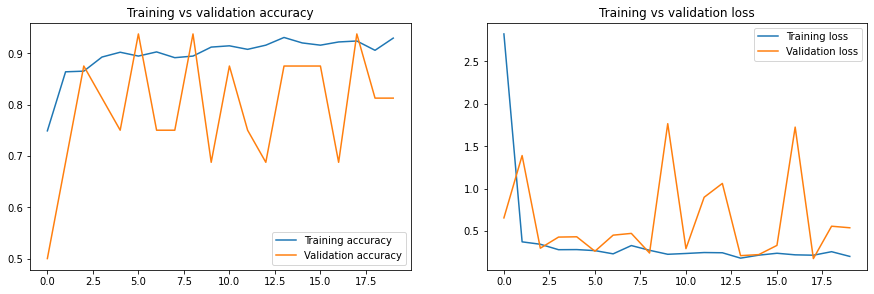

In [27]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()